# Plot 0.05-degree data in North America for a given month


In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import plot

In [3]:
res = 0.05
extents = {"lon0_b": -125, "lon1_b": -65, "lat0_b": 22, "lat1_b": 58}
ds_grid = xe.util.cf_grid_2d(**extents, d_lon=res, d_lat=res)
df_grid = ds_grid.to_dataframe().reset_index()
df_grid


,lon,bound,lat,lon_bounds,lat_bounds,latitude_longitude
0,-124.975,0,22.025,-125.0,22.00,NaN
1,-124.975,0,22.075,-125.0,22.05,NaN
2,-124.975,0,22.125,-125.0,22.10,NaN
3,-124.975,0,22.175,-125.0,22.15,NaN
4,-124.975,0,22.225,-125.0,22.20,NaN
...,...,...,...,...,...,...
1727995,-65.025,1,57.775,-65.0,57.80,NaN
1727996,-65.025,1,57.825,-65.0,57.85,NaN
1727997,-65.025,1,57.875,-65.0,57.90,NaN
1727998,-65.025,1,57.925,-65.0,57.95,NaN


In [4]:
ds_grid

<xarray.Dataset>
Dimensions:             (lon: 1200, bound: 2, lat: 720)
Coordinates:
  * lon                 (lon) float64 -125.0 -124.9 -124.9 ... -65.08 -65.03
  * lat                 (lat) float64 22.02 22.08 22.12 ... 57.88 57.93 57.98
    latitude_longitude  float64 nan
Dimensions without coordinates: bound
Data variables:
    lon_bounds          (bound, lon) float64 -125.0 -125.0 ... -65.05 -65.0
    lat_bounds          (bound, lat) float64 22.0 22.05 22.1 ... 57.9 57.95 58.0

In [5]:
# with xr.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc") as ds:
#     ds = ds.where(ds.time.dt.year == 2016, drop=True)
#     ds = ds.where(ds.time.dt.month == 7, drop=True)
#     bounds = (
#         (ds.lon >= extents["lon0_b"])
#         & (ds.lon <= extents["lon1_b"])
#         & (ds.lat >= extents["lat0_b"])
#         & (ds.lat <= extents["lat1_b"])
#     )
#     ds = ds.where(bounds, drop=True)
#     m_start = np.datetime_as_string(ds.time.min(), unit="D")
#     m_end = np.datetime_as_string(ds.time.max(), unit="D")
#     df = ds.to_dataframe().reset_index()

# df.to_csv("OCO2_Lite_SIF740_north_america_201607.csv")

df = pd.read_csv("OCO2_Lite_SIF740_north_america_201607.csv")

df = df[["sif", "lon", "lat"]]
df

,sif,lon,lat
0,0.404351,-70.915590,41.704530
1,0.139903,-70.922360,41.722900
2,0.845830,-70.916565,41.713380
3,0.172018,-70.910770,41.703796
4,0.064241,-70.929200,41.741210
...,...,...,...
414125,0.468597,-124.973020,50.886963
414126,0.288103,-124.992065,50.914185
414127,0.273060,-124.981750,50.906740
414128,0.587591,-124.990420,50.926514


In [11]:
# overwrite lon-lat values with grid values
# lon_bounds = np.append(ds_grid.lon_bounds.values[0, :], ds_grid.lon_bounds.values[1, -1])
# lat_bounds = np.append(ds_grid.lat_bounds.values[0, :], ds_grid.lat_bounds.values[1, -1])
# df["lon"] = pd.cut(df.lon, lon_bounds, labels=ds_grid.lon.values).astype(float)
# df["lat"] = pd.cut(df.lat, lat_bounds, labels=ds_grid.lat.values).astype(float)

test = df.groupby(["lon", "lat"]).mean().to_xarray()
test

<xarray.Dataset>
Dimensions:  (lon: 1200, lat: 720)
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.9 -124.8 ... -65.13 -65.08 -65.03
  * lat      (lat) float64 22.02 22.08 22.12 22.18 ... 57.83 57.88 57.93 57.98
Data variables:
    sif      (lon, lat) float64 nan nan nan nan nan ... 0.07965 nan nan nan nan

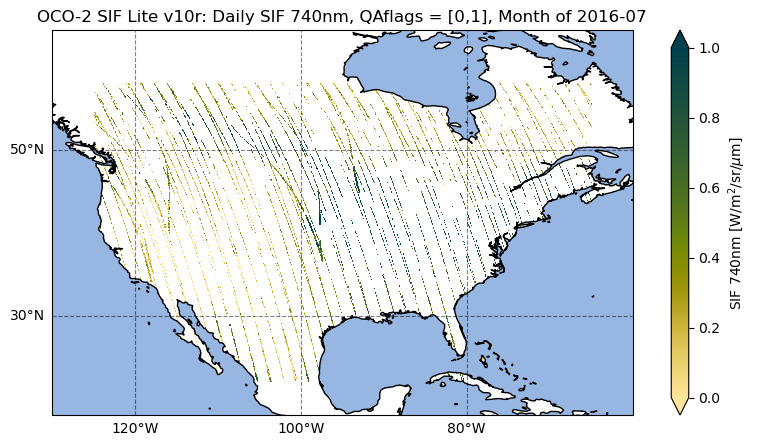

In [13]:
title = f"OCO-2 SIF Lite v10r: Daily SIF 740nm, QAflags = [0,1], Month of 2016-07"
units = "SIF 740nm [W/m$^2$/sr/$\mu$m]"
plot.plot_da(test["sif"], vmin=0, vmax=1, title=title, label=units)